52.420431 4.8810259
52.420219 4.8814458
52.4166172 4.8828852
52.4165291 4.8825447
52.4161839 4.8920308
52.4162683 4.893282
52.4147289 4.8811392
52.4299931 4.8641859
52.4225328 4.9527727
52.4225883 4.9523131
52.4219657 4.9547115
52.3054856 4.9464075
52.3078114 4.9442557
52.3044188 4.9469146
52.3775878 4.8463385
52.3127497 4.9499148
52.3621301 4.8808701
52.3415953 4.7932054
52.3418043 4.7932052
52.4201262 4.8930079
52.4200771 4.892863
52.4211175 4.8918905
52.4219883 4.8911774
52.4245606 4.8886412
52.4246113 4.888683
52.354496 4.9507867
52.3543431 4.9582997
52.3559759 4.9541376
52.3552122 4.9526721
52.3546283 4.9507583
52.3547493 4.952165
52.3577153 4.9442634
52.357613 4.9446655
52.3589967 4.9408343
52.3613445 4.9328607
52.3523594 4.9477449
52.3487119 4.9414936
52.3455153 4.9365555
52.3458716 4.9318949
52.3463777 4.9314393
52.3472783 4.928604
52.3460025 4.9243303
52.3458631 4.9246407
52.3656126 4.8042516
52.3659913 4.8042144
52.3702166 4.8514928
52.3703961 4.8500384
52.3701648 4.8507854
5

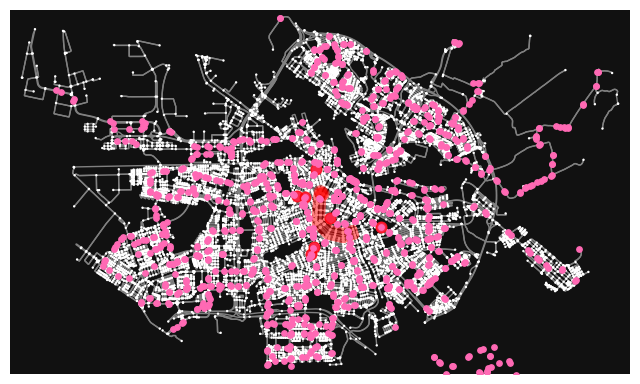

Nearest Tram Stop Details:
OBJECTNUMMER: Koningsplein
Modaliteit: Tram
Lijn: 2 | 12
Lijn_select: 02|12
RADIUS: 5
Label: 2 | 12 - Koningsplein
WKT_LNG_LAT: POINT(4.8891545 52.3678894)
WKT_LAT_LNG: POINT(52.3678894 4.8891545)
LNG: 4.8891545
LAT: 52.3678894
Column1: nan
distance_to_center: 0.1146133355505646
No tram stops found within 2 km of the central point.


In [1]:

import osmnx as ox #  to download, model, analyze, and visualize- OpenStreetMap
import networkx as nx #manipulation, and study of the structure, dynamics, and functions of complex networks.
from haversine import haversine #to get the distances - points on EARTH 
import matplotlib.pyplot as plt #Since the trams stops are missing in streetmap, we need to overlay this from an excel sheet
import pandas as pd #also for reading the excel sheets

#get the central point, Romane already got us the coordinates :)
central_point = (52.368622, 4.890342)
radius = 2 #is in km, so 2 km now

# To retrieve the street network from Amsterdam - osmnx
G = ox.graph_from_place('Amsterdam, Netherlands', network_type='drive')

# OVERLAY busstops & calculating the coordinates ; features_from_place is on spatial features while. Geometries_from_place is more on the coordinates
bus_stops = ox.features_from_place('Amsterdam, Netherlands', tags={'highway': 'bus_stop'})
bus_stops_coordinates = ox.features_from_place('Amsterdam, Netherlands', tags={'highway': 'bus_stop'})

 #Loading the .csv in python
excel_path = 'TRAMMETRO_PUNTEN_2022.csv'
column_names = ["OBJECTNUMMER", "Modaliteit", "Lijn", "Lijn_select", "RADIUS", "Label", "WKT_LNG_LAT", "WKT_LAT_LNG", "LNG", "LAT", "Column1"] # List the column names in order
df = pd.read_csv(excel_path, names=column_names, delimiter=';')
df['LAT'] = pd.to_numeric(df['LAT'], errors='coerce')
df['LNG'] = pd.to_numeric(df['LNG'], errors='coerce')
df['LAT'] = df['LAT'] / 10000000  # to get the right latitude number, now it is 52...
df['LNG'] = df['LNG'] / 10000000  # to get the right longitude number, now it is 4.. 

 #Making the columns a python list via .tolist
latitudes = df['LAT'].tolist() 
longitudes = df['LNG'].tolist()

#the distance from the busstops from the central point. Lambda is a function to define all, anonymous functions without a name; lambda x: x.y 
bus_stops['latitude'] = bus_stops['geometry'].apply(lambda x: x.y)
bus_stops['longitude'] = bus_stops['geometry'].apply(lambda x: x.x)
bus_stops['distance_to_center'] = bus_stops.apply(lambda row: haversine(central_point, (row['latitude'], row['longitude'])), axis=1)
#filtering try 2
filtered_bus_stops = bus_stops[bus_stops['distance_to_center'] <= radius] 

 #filtering tramstops, different than with busstops, since it is a csv
df['distance_to_center'] = df.apply(lambda row: haversine(central_point, (row['LAT'], row['LNG'])), axis=1)
filtered_tram_stops = df[df['distance_to_center'] <= radius]


# Our route- coordinates
start_point = (52.375970817111615, 4.884275426236839)
intermediate_points = [
    (52.374875778140606, 4.883157426755103),
    (52.3746402301901, 4.883117183908737),
    (52.3666596934746, 4.882403398639854),
    (52.36612419604963, 4.882874431008837),
    (52.36279237064189, 4.887823317102019),
    (52.36163442469799, 4.896087082648911),
    (52.36277303219077, 4.902271083397273),
    (52.3644383133346, 4.901412424669542),
    (52.36342339947044, 4.895891438917263),
    (52.36429654186616, 4.88938410885678),
    (52.366935295442254, 4.8848300652041825),
    (52.36726320666577, 4.884519657126263),
    (52.37442103381968, 4.885134598764678),

]
end_point = (52.37540453652578, 4.885844213413374)

# Find the nearest nodes for all points
nodes = [ox.distance.nearest_nodes(G, X=pt[1], Y=pt[0]) for pt in [start_point] + intermediate_points + [end_point]]

# full route from coordinates- loophole
full_route = []
for i in range(len(nodes) - 1):
    segment = nx.shortest_path(G, nodes[i], nodes[i + 1], weight='length') 
    full_route += segment[:-1]  # Exclude the last node to avoid duplication

full_route.append(nodes[-1])  # Add the end point

# Plot the full route from osmnx; 
fig, ax = ox.plot_graph(G, node_size=3, edge_color="gray", show=False, close=False)

ax.set_aspect('equal') #just to know for sure that the axis are equal

#to check if OSMnx has the data below in it's database
if bus_stops is not None and not bus_stops.empty:
    bus_stops.plot(ax=ax, color='hotpink', markersize=15)
if filtered_tram_stops is not None: #If there is a value regarding tram stops, than plot it
    ax.scatter(filtered_tram_stops['LNG'], filtered_tram_stops['LAT'], color='red', s=60, alpha=0.7, zorder=2)
#OSMnx has information about bus stops and canals, but not about trams. So we need to get an excel sheet to get that information

#Question 3: closest bus and tram stops at the start and finish of the swimming route. We choose to do the closest busstops & tramsstops from our centrality point. 

#Getting the coordinates from the busstops - in OSMnx
bus_stops_coordinates = list(bus_stops['geometry'].apply(lambda geom: (geom.y, geom.x)))
for lat, lon in bus_stops_coordinates:
    print(lat, lon)

#If statement for filter busstops
if not filtered_bus_stops.empty:
    filtered_bus_stops.plot(ax=ax, color='hotpink', markersize=15, marker='o', zorder=3)

#printing the filtered busstops
for _, row in filtered_bus_stops.iterrows():
    print(row['latitude'], row['longitude']) 

#TRAMS

 #for printing the tramstops
for index, row in filtered_tram_stops.iterrows():
     print(f"Latitude: {row['LAT']}, Longitude: {row['LNG']}, Distance to Center: {row['distance_to_center']}")
ax.scatter(filtered_tram_stops['LNG'], filtered_tram_stops['LAT'], color='violet', s=50)

sorted_tram_stops = filtered_tram_stops.sort_values(by='distance_to_center', ascending=True)

# to calculate the closest tramstop
if not sorted_tram_stops.empty:
      nearest_tram_stop = sorted_tram_stops.iloc[...]  
      print(f"Nearest Tram Stop, Distance to Center: {nearest_tram_stop['distance_to_center']} km")
else:
      print(f"No tram stops found within {radius} km of the central point.")
  # plotting the route
ox.plot_graph_route(G, full_route, route_linewidth=6, node_size=3, ax=ax, close= False, show = False)
plt.show()

 # Sort filtered_tram_stops based on distance_to_center
sorted_tram_stops = filtered_tram_stops.sort_values(by='distance_to_center', ascending=True)

 # retrieving the other info from the cvs in that row. 
if not sorted_tram_stops.empty:
     nearest_tram_stop = sorted_tram_stops.iloc[0]  
print("Nearest Tram Stop Details:")
for column in nearest_tram_stop.index:
         print(f"{column}: {nearest_tram_stop[column]}")
else:
     print(f"No tram stops found within {radius} km of the central point.")



In [2]:
def compute_average_stops(filename):
    hours = []

    with open(filename, "r") as fhandle:
        for lines in fhandle:
            line_data = lines.split()
            frequency = len(line_data) - 1
            hours.append(frequency)

    total_stops = sum(hours)
    average_stops = total_stops / len(hours)
    return average_stops

# Define the paths for each tram line and day type
datasets = {
    "weekdays": [
        "DATA line 12 tram.txt",
        "line 2 Weekdays.txt"
    ],
    "saturdays": [
        "saturday line 12.txt",
        "line 2 saturday.txt"
    ],
    "sundays and holidays": [
        "line 12 sunday and holidays.txt",
        "DATA line 12 tram.txt"  # Is this path correct for line 2?
    ]
}

for day_type, files in datasets.items():
    total_average = sum(compute_average_stops(filename) for filename in files)
    print(f"Total average stops for tramlines 2 and 12 on {day_type}: {round(total_average,)}")
    print(f"The max amount of people travelling with both trams on {day_type}: {round(total_average * 150,)}")



Total average stops for tramlines 2 and 12 on weekdays: 13
The max amount of people travelling with both trams on weekdays: 2010
Total average stops for tramlines 2 and 12 on saturdays: 14
The max amount of people travelling with both trams on saturdays: 2055
Total average stops for tramlines 2 and 12 on sundays and holidays: 12
The max amount of people travelling with both trams on sundays and holidays: 1852
